In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astroquery.ned import Ned
from astropy import coordinates
import astropy.units as u
import os
os.environ['SFD_DIR'] = '/home/mi/sfddata-master' 
os.environ['SIRAHPIPE_DIR'] = os.getcwd()

In [3]:
oid = 'ZTF20aauowam'
z = None
zerr = 0.001
if oid.startswith('ZTF'):
    source = 'ztf'
    broker = 'alerce'
else:
    source = 'tns'

In [4]:
def query_ned(ra,dec):
    co = coordinates.SkyCoord(ra=ra, dec=dec, unit=(u.deg, u.deg), frame='fk5')
    Ned_table = Ned.query_region(co, radius=0.02 * u.deg, equinox='J2000.0')
    Ned_table['Type'] = Ned_table['Type'].astype(str)
    if 'G' in Ned_table['Type'].astype(str):
        res = Ned_table[Ned_table['Type'] == 'G']
    else:
        res = None
    return res 

In [5]:
def query_glade(ra,dec,oid):
    from cross_match_host import GLADEQuery
    glade = GLADEQuery()
    sncoor = pd.DataFrame([{'meanra':ra.values[0],'meandec':dec.values[0],'oid':oid.values[0]}])
    glade.run(sncoor)
    return glade.queryresult


In [6]:
# query oid
if source == 'ztf':
    if broker == 'alerce':
        from broker_query import Alerce
        alerce = Alerce()
        alerce.setup()
        query = '''
                select objects.oid, objects.nobs, objects.meanra, objects.meandec, objects.firstmjd, objects.lastmjd,
                objects.first_magpsf_g, objects.first_magpsf_r, objects.last_magpsf_g, objects.last_magpsf_r, objects.classearly
                from objects 
                where objects.oid = '{}'
                '''.format(oid)
        alerce.load_query(query)
        alerce.make_query()
        target = alerce.queryresult
    
    if broker == 'lasair':
        from broker_query import Lasair
        lasair = Lasair()
        lasair.setup()
        query = '''
                select objects.objectId, objects.ncand, objects.ramean, objects.decmean, objects.jdmin-2400000.5, objects.jdmax-2400000.5,
                objects.magrmax, objects.latestrmag, objects.maggmax, objects.latestgmag
                from objects 
                where objects.objectId = '{}'
                '''.format(oid)
        lasair.load_query(query)
        lasair.qcols = ['oid','nobs','meanra','meandec','firstmjd','lastmjd',
                        'first_magpsf_r','last_magpsf_r','first_magpsf_g','last_magpsf_g']
        lasair.make_query()
        target = lasair.queryresult
    
if source == 'tns':
    from tnsScrape import get_tns_data
    target = get_tns_data(oid)['meta']
    target['meanra'] = target['radeg']
    target['meandec'] = target['decdeg']
    target['oid'] = oid
    target['Broker'] = 'tns'
else:
    target['Broker'] = 'alerce'

if z is None:
    host = query_ned(target['meanra'],target['meandec']).to_pandas().dropna().sort_values('Separation',ascending=True).reset_index(drop=True)
    display(host[['Object Name','RA','DEC','Redshift','Separation']])
    z = host['Redshift'][0]
#     host = query_glade(target['meanra'],target['meandec'],target['oid'])
#     display(host)
target['z'] = z
target['zerr'] = zerr
display(target)

queryresult size: 1


,Object Name,RA,DEC,Redshift,Separation
0,b'WISEA J153433.10+373155.6',233.63792,37.53209,0.064391,0.105


,oid,nobs,meanra,meandec,firstmjd,lastmjd,first_magpsf_g,first_magpsf_r,last_magpsf_g,last_magpsf_r,classearly,Broker,z,zerr
0,ZTF20aauowam,10,233.637668,37.533828,58943.45853,58956.365949,20.1138,20.287695,17.770088,17.975595,19,alerce,0.064391,0.001


ZTF20aauowam: z=0.0644 +/- 0.0010
ra = 15:34:33.040 dec = +37:32:01.78 mwebv=0.014


{'z': 0.064391, 't0': 58959.427147194954, 'x0': 0.0012644068615701443, 'x1': 1.0020056935805952, 'c': -0.030525295311231382, 'mwebv': 0.013708615522319481}


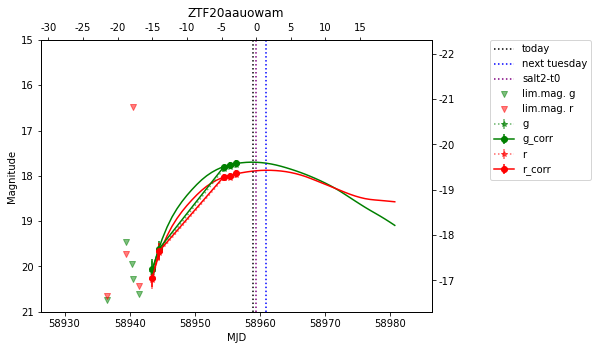

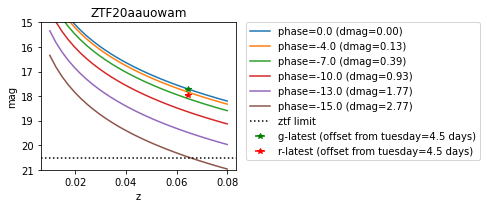

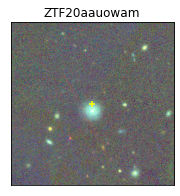

In [55]:
from utils import *
import matplotlib.pyplot as plt
import os
from PyPDF2 import PdfFileMerger
# %matplotlib inline

from astropy.time import Time
from datetime import datetime,date
querydate = datetime.today()

interactive = False
savepdf = False

if savepdf:
    folder = 'data/screenshots/individual_runs/{}'.format(querydate.strftime("%m-%d-%Y"))
    if not os.path.isdir(folder):
        os.mkdir(folder)
#     pdflist = []
# display(target[target.oid=='ZTF20aamfpft'])
for i,row in target.iterrows():
    if savepdf:
        f = '{}/{}.pdf'.format(folder,row.oid)
    else:
        f = None
    res = gen_plots(row,interactive=interactive,pdf_file=f,magabs=-19.6,extra_lc=False,last_detection_max=1000,
                    source=source,lc_prediction=False,update_lc_prediction=True,plot_ylim=(21,15),ps1_image_size=500,
                    plot_salt2_lc=True)
#     if not res['too_old'] and savepdf:
#         pdflist.append(f) 
# if savepdf:
#     merger = PdfFileMerger()
#     for pdf in pdflist:
#         merger.append(pdf)
#     merger.write(pdf_file)
#     merger.close()

In [20]:
df = pd.read_csv('data/extra_photometry/2020ftl_data.snana.txt',sep='\s+',comment='#')

In [21]:
df = df[df.FLT != 'Unknown']
df['FLT'] = [x.split('-')[0] for x in df.FLT]

In [22]:
df = df.rename(columns={'MJD':'mjd','MAGERR':'magerr','MAG':'mag','FLT':'filter'})
df.to_csv('data/extra_photometry/2020ftl.txt')

In [ ]:
df['magcorr'] = 0.
for f in df['filter']:
    df.loc[df['filter'] ==f, 'magcorr'] = df.loc[df['filter']==f,'mag'] - mwebv_corr(target['meanra'],target['meandec'],f)

In [ ]:
from utils import mwebv_corr

In [ ]:
mwebv_corr(target['meanra'],target['meandec'],'g'),mwebv_corr(target['meanra'],target['meandec'],'r')

In [ ]:
df['magorig'] = df['mag']
df['mag'] = df['magcorr']